In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import data_processing 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence

from sklearn.inspection import PartialDependenceDisplay
import shap
from sklearn.inspection import permutation_importance
import importlib
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
import models
importlib.reload(data_processing)

<module 'data_processing' from '/home/robin/uu/hcml/HCML_Project/data_processing.py'>

In [47]:
x_train, x_test, y_train, y_test = data_processing.data_selected_features()

In [48]:
### SHAP
def get_shap_values(model, x_train, x_test):
    explainer = shap.KernelExplainer(model.predict,x_train)
    shap_values = explainer.shap_values(x_test)
    return shap_values


In [58]:
def get_random_feature(x_train, x_test, distributions, split_column= None, scaling = 0.01):
    if split_column ==  "":
        return  distributions[0], distributions[1]
    else:
        return x_train.copy()[split_column] + distributions[0] * scaling, x_test.copy()[split_column] + distributions[1] * scaling

        

In [61]:

# beta 
normal = (np.random.normal(0,1,  size=x_train.shape[0]), np.random.normal(0,1,  size=x_test.shape[0]))
betaU = (np.random.beta(1/2,1/2,  size=x_train.shape[0]),np.random.beta(1/2,1/2,  size=x_test.shape[0]))
betaL = (np.random.beta(1/2,1/2,  size=x_train.shape[0]), np.random.beta(1/2,1/2,  size=x_test.shape[0]))


distributions = [normal, betaU, betaL]
distributions_names = ["normal", "betaU", "betaL"]
sharp_results = {}
ebm_results = {}
split_column = ["", "Minimum Orbit Intersection", "Absolute Magnitude"]
for split in split_column:
    for names, dis in zip(distributions_names, distributions):
        x_train["Random"] , x_test["Random"] = get_random_feature(x_train, x_test, dis, split_column=split)
        
        nn = models.nn_model()
        nn.fit(x_train, y_train)
        shap_values = get_shap_values(nn, x_train, x_test)    
        sharp_results[f"{names}{split}"] = shap_values
        
        ebm = ExplainableBoostingClassifier().fit(x_train, y_train)
        ebm_values = data_processing.normalize_data(ebm.term_importances()[0:len(x_train.columns)])

        ebm_results[f"{names}{split}"] = ebm_values

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
def plot_bar(shap_values, ebm_values, columns, header="test"):
    df = pd.DataFrame({"feature" : columns, "EBM": ebm_values,"NN": abs(shap_values) } )
    df.sort_values(by=["NN"], inplace = True)
    
    df.plot.barh(x = 'feature', y = ['EBM', 'NN'], color={"EBM": "#FFCD00", "NN": "#AA1555"}, title=header)
    plt.show()
    

In [40]:
def plot_distribution(distributions, header):
    
    # plot beta distribution
    plt.hist(distributions, bins=100)
    plt.title(header)
    plt.show()
    


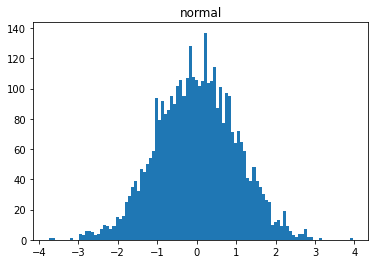

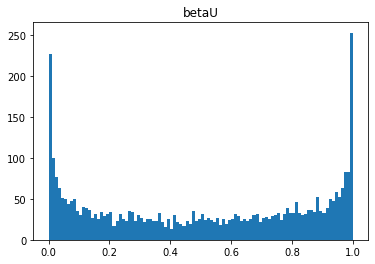

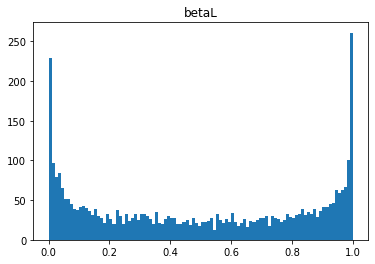

In [64]:
for name, dist in zip(distributions_names, distributions):
    plot_distribution(dist[0], name)

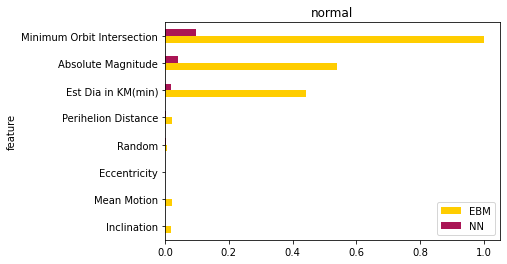

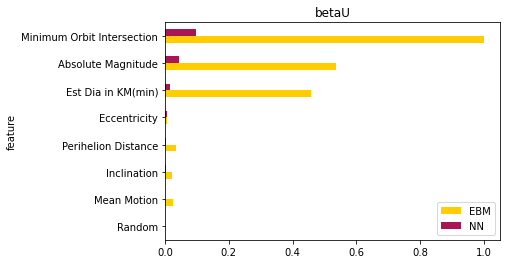

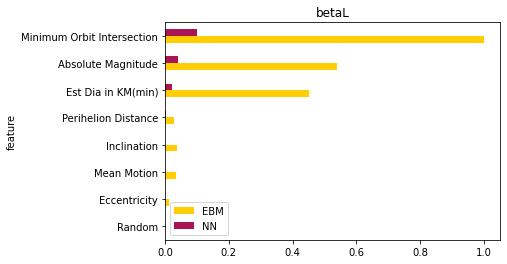

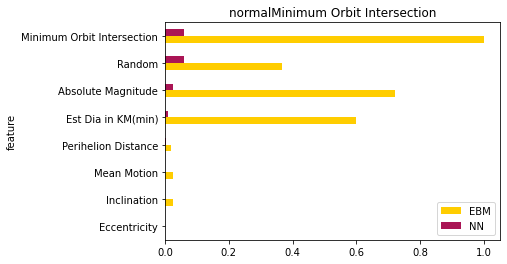

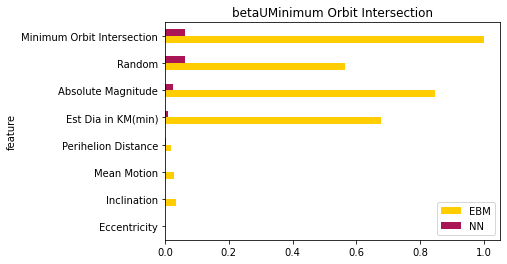

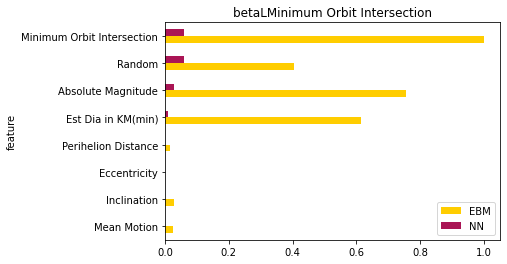

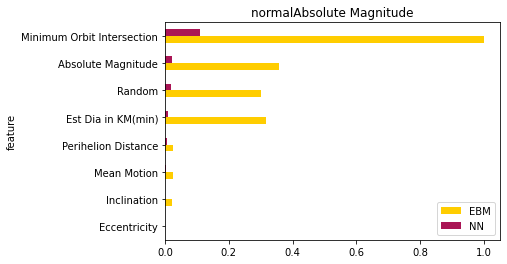

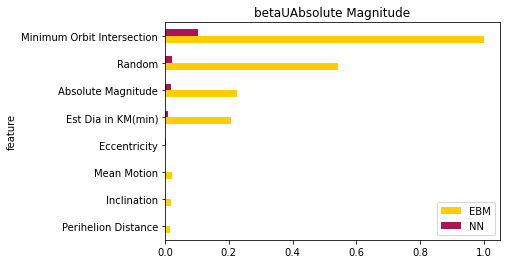

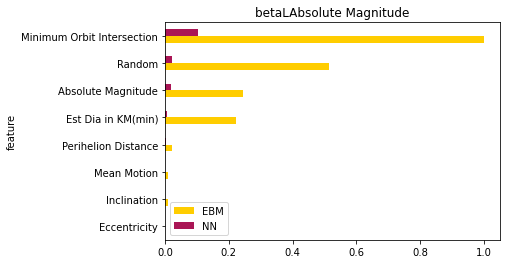

In [62]:

#fig, axs = plt.subplots(2,4)
for split in split_column:
    for dist in distributions_names:
        plot_bar(sharp_results[f"{dist}{split}"].mean(axis=0), ebm_results[f"{dist}{split}"], x_train.columns, f"{dist}{split}")
